결과요약: RMSE: 0.24234837293624878  이상점 제거+normalize함

개인적으로 이상점을 제거한 후 normalize를 하면 rmse가 커질 수 밖에 없다고 생각함. 다음시도(lstm3)은 이상점을 제거하지 않고 normalize를 하고, lstm4에서는 이상점을 제거하고 normalize를 하지 않는 것을 시도하겠다.

Data import

시도 내용 요약:
주중(1)/주말(2) + 겨울(1)봄(2)여름(3)가을(4) // 

이미 lstm이라는 것이 sequence 개념이 있으므로 시간축(1~397)를 feature로 설정하는 것은 의미가 없을 듯 하여 LSTM 시도2에서는 제외함

https://bigdatascientistblog.wordpress.com/2015/10/02/feature-engineering-with-dates-part-1/

에 따르면 날짜 datestampe에서 9가지의 특성을 끌어낼 수 있다고 한다. 따라서 이를 적용해보고자 한다.

year, month, day, day of week, week of year, hour of day

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
tf.set_random_seed(7)


In [2]:
columns=['date','sales']

txs=pd.read_table('./lstmData/lstmPrac2.csv', sep=',',header=None,names=columns )
txs.info()
txs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
date     397 non-null object
sales    397 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.3+ KB


,date,sales
0,2016-01-01,34
1,2016-01-02,41
2,2016-01-03,54
3,2016-01-04,41
4,2016-01-05,35


In [3]:
from datetime import datetime                    

# 1. 기본 feature

In [4]:
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year  
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
# please read docs on how week numbers are calculate
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d" ).strftime('%V')

# 2. 추가 feature

In [5]:
seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d" ).month-1)]

In [6]:
txs['year'] = txs['date'].map(year)
txs['month']=txs['date'].map(month)
txs['week_number']=txs['date'].map(week_number)
txs['season']=txs['date'].map(season)
txs['day_of_week']=txs['date'].map(day_of_week)
# txs['week_number']=txs['date'].map(week_number)
txs

,date,sales,year,month,week_number,season,day_of_week
0,2016-01-01,34,2016,1,53,0,4
1,2016-01-02,41,2016,1,53,0,5
2,2016-01-03,54,2016,1,53,0,6
3,2016-01-04,41,2016,1,01,0,0
4,2016-01-05,35,2016,1,01,0,1
5,2016-01-06,44,2016,1,01,0,2
6,2016-01-07,50,2016,1,01,0,3
7,2016-01-08,42,2016,1,01,0,4
8,2016-01-09,42,2016,1,01,0,5
9,2016-01-10,66,2016,1,01,0,6


pandas를 통해 구한 각 feature는 list()로 우리의 기준type인 list로 변경이 가능

# 3. 추가 가공

이상점 제거, normalization, bucketization 을 하여 새로운 열을 생성하는 방향으로

이상점 제거를 위해 평균과 표준편차를 구한다. 이상점의 기준은 일단 평균+-2*sd로 설정

In [7]:
xySales=txs['sales']

In [8]:
xySales=list(xySales)

In [9]:
mean=np.mean(xySales)
mean

35.191435768261968

In [10]:
std=np.std(xySales)
std

36.518152240039889

In [11]:
for i in range(len(xySales)):
    if (xySales[i]<mean-2*std or xySales[i]>mean+2*std):
         xySales[i]=int(mean)
        

In [12]:
xySales

[34,
 41,
 54,
 41,
 35,
 44,
 50,
 42,
 42,
 66,
 50,
 55,
 56,
 53,
 44,
 54,
 54,
 50,
 40,
 49,
 28,
 72,
 71,
 53,
 43,
 38,
 55,
 49,
 43,
 49,
 49,
 44,
 39,
 52,
 45,
 33,
 43,
 40,
 46,
 49,
 50,
 37,
 37,
 45,
 48,
 48,
 38,
 60,
 31,
 35,
 53,
 70,
 62,
 48,
 51,
 49,
 38,
 32,
 39,
 35,
 30,
 36,
 31,
 31,
 44,
 41,
 41,
 45,
 46,
 45,
 41,
 47,
 48,
 40,
 42,
 38,
 38,
 45,
 48,
 62,
 46,
 38,
 62,
 81,
 40,
 45,
 42,
 53,
 53,
 56,
 53,
 47,
 61,
 64,
 62,
 37,
 65,
 54,
 44,
 46,
 50,
 43,
 53,
 63,
 52,
 2,
 0,
 0,
 72,
 59,
 75,
 47,
 44,
 77,
 90,
 93,
 47,
 61,
 77,
 35,
 50,
 58,
 33,
 41,
 36,
 64,
 49,
 53,
 60,
 43,
 41,
 55,
 45,
 18,
 60,
 69,
 54,
 39,
 50,
 44,
 54,
 57,
 82,
 57,
 44,
 56,
 51,
 55,
 28,
 56,
 54,
 36,
 12,
 25,
 41,
 11,
 6,
 9,
 35,
 29,
 24,
 23,
 14,
 21,
 20,
 25,
 23,
 27,
 31,
 16,
 14,
 30,
 32,
 75,
 35,
 26,
 12,
 21,
 23,
 28,
 25,
 31,
 21,
 17,
 10,
 29,
 34,
 28,
 20,
 36,
 23,
 15,
 42,
 28,
 24,
 29,
 20,
 14,
 18,
 27,
 22,


In [13]:
def MinMaxScaler(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

In [14]:
xySales=MinMaxScaler(xySales)

In [15]:
xySales

array([ 0.34,  0.41,  0.54,  0.41,  0.35,  0.44,  0.5 ,  0.42,  0.42,
        0.66,  0.5 ,  0.55,  0.56,  0.53,  0.44,  0.54,  0.54,  0.5 ,
        0.4 ,  0.49,  0.28,  0.72,  0.71,  0.53,  0.43,  0.38,  0.55,
        0.49,  0.43,  0.49,  0.49,  0.44,  0.39,  0.52,  0.45,  0.33,
        0.43,  0.4 ,  0.46,  0.49,  0.5 ,  0.37,  0.37,  0.45,  0.48,
        0.48,  0.38,  0.6 ,  0.31,  0.35,  0.53,  0.7 ,  0.62,  0.48,
        0.51,  0.49,  0.38,  0.32,  0.39,  0.35,  0.3 ,  0.36,  0.31,
        0.31,  0.44,  0.41,  0.41,  0.45,  0.46,  0.45,  0.41,  0.47,
        0.48,  0.4 ,  0.42,  0.38,  0.38,  0.45,  0.48,  0.62,  0.46,
        0.38,  0.62,  0.81,  0.4 ,  0.45,  0.42,  0.53,  0.53,  0.56,
        0.53,  0.47,  0.61,  0.64,  0.62,  0.37,  0.65,  0.54,  0.44,
        0.46,  0.5 ,  0.43,  0.53,  0.63,  0.52,  0.02,  0.  ,  0.  ,
        0.72,  0.59,  0.75,  0.47,  0.44,  0.77,  0.9 ,  0.93,  0.47,
        0.61,  0.77,  0.35,  0.5 ,  0.58,  0.33,  0.41,  0.36,  0.64,
        0.49,  0.53,

In [16]:
tempxy=[list(txs['season']),list(txs['day_of_week']),list(txs['week_number']),xySales]

In [17]:
tempxy

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,


In [18]:
xy=np.array(tempxy)

In [19]:
xy

array([['0', '0', '0', ..., '0', '0', '0'],
       ['4', '5', '6', ..., '6', '0', '1'],
       ['53', '53', '53', ..., '04', '05', '05'],
       ['0.33999999966', '0.40999999959', '0.53999999946', ..., '0.0',
        '0.049999999950000006', '0.30999999969']], 
      dtype='<U32')

In [20]:
temp=xy.transpose()

In [21]:
temp

array([['0', '4', '53', '0.33999999966'],
       ['0', '5', '53', '0.40999999959'],
       ['0', '6', '53', '0.53999999946'],
       ..., 
       ['0', '6', '04', '0.0'],
       ['0', '0', '05', '0.049999999950000006'],
       ['0', '1', '05', '0.30999999969']], 
      dtype='<U32')

In [22]:
xy = temp.astype(np.float)

In [23]:
xy

array([[  0.00000000e+00,   4.00000000e+00,   5.30000000e+01,
          3.40000000e-01],
       [  0.00000000e+00,   5.00000000e+00,   5.30000000e+01,
          4.10000000e-01],
       [  0.00000000e+00,   6.00000000e+00,   5.30000000e+01,
          5.39999999e-01],
       ..., 
       [  0.00000000e+00,   6.00000000e+00,   4.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   5.00000000e+00,
          5.00000000e-02],
       [  0.00000000e+00,   1.00000000e+00,   5.00000000e+00,
          3.10000000e-01]])

[[  0.     4.    53.     0.34]
 [  0.     5.    53.     0.41]
 [  0.     6.    53.     0.54]
 [  0.     0.     1.     0.41]
 [  0.     1.     1.     0.35]
 [  0.     2.     1.     0.44]
 [  0.     3.     1.     0.5 ]] -> [ 0.42]
[[  0.     5.    53.     0.41]
 [  0.     6.    53.     0.54]
 [  0.     0.     1.     0.41]
 [  0.     1.     1.     0.35]
 [  0.     2.     1.     0.44]
 [  0.     3.     1.     0.5 ]
 [  0.     4.     1.     0.42]] -> [ 0.42]
[[  0.     6.    53.     0.54]
 [  0.     0.     1.     0.41]
 [  0.     1.     1.     0.35]
 [  0.     2.     1.     0.44]
 [  0.     3.     1.     0.5 ]
 [  0.     4.     1.     0.42]
 [  0.     5.     1.     0.42]] -> [ 0.66]
[[ 0.    0.    1.    0.41]
 [ 0.    1.    1.    0.35]
 [ 0.    2.    1.    0.44]
 [ 0.    3.    1.    0.5 ]
 [ 0.    4.    1.    0.42]
 [ 0.    5.    1.    0.42]
 [ 0.    6.    1.    0.66]] -> [ 0.5]
[[ 0.    1.    1.    0.35]
 [ 0.    2.    1.    0.44]
 [ 0.    3.    1.    0.5 ]
 [ 0.    4.    1.    0.42]
 [ 0.

 [  0.     1.    50.     0.22]] -> [ 0.19]
[[  0.     3.    49.     0.21]
 [  0.     4.    49.     0.35]
 [  0.     5.    49.     0.15]
 [  0.     6.    49.     0.06]
 [  0.     0.    50.     0.23]
 [  0.     1.    50.     0.22]
 [  0.     2.    50.     0.19]] -> [ 0.2]
[[  0.     4.    49.     0.35]
 [  0.     5.    49.     0.15]
 [  0.     6.    49.     0.06]
 [  0.     0.    50.     0.23]
 [  0.     1.    50.     0.22]
 [  0.     2.    50.     0.19]
 [  0.     3.    50.     0.2 ]] -> [ 0.13]
[[  0.     5.    49.     0.15]
 [  0.     6.    49.     0.06]
 [  0.     0.    50.     0.23]
 [  0.     1.    50.     0.22]
 [  0.     2.    50.     0.19]
 [  0.     3.    50.     0.2 ]
 [  0.     4.    50.     0.13]] -> [ 0.21]
[[  0.     6.    49.     0.06]
 [  0.     0.    50.     0.23]
 [  0.     1.    50.     0.22]
 [  0.     2.    50.     0.19]
 [  0.     3.    50.     0.2 ]
 [  0.     4.    50.     0.13]
 [  0.     5.    50.     0.21]] -> [ 0.1]
[[  0.     0.    50.     0.23]
 [  0.     1

[step: 37] loss: 5.820273399353027
[step: 38] loss: 5.82775354385376
[step: 39] loss: 5.824134349822998
[step: 40] loss: 5.809050559997559
[step: 41] loss: 5.784121513366699
[step: 42] loss: 5.752387046813965
[step: 43] loss: 5.717580318450928
[step: 44] loss: 5.683389186859131
[step: 45] loss: 5.652851104736328
[step: 46] loss: 5.627946853637695
[step: 47] loss: 5.60945463180542
[step: 48] loss: 5.597023963928223
[step: 49] loss: 5.58941650390625
[step: 50] loss: 5.584869384765625
[step: 51] loss: 5.581468105316162
[step: 52] loss: 5.577507019042969
[step: 53] loss: 5.571753025054932
[step: 54] loss: 5.563596248626709
[step: 55] loss: 5.553068161010742
[step: 56] loss: 5.540746212005615
[step: 57] loss: 5.527565956115723
[step: 58] loss: 5.514565944671631
[step: 59] loss: 5.5026679039001465
[step: 60] loss: 5.492462158203125
[step: 61] loss: 5.4841156005859375
[step: 62] loss: 5.477357387542725
[step: 63] loss: 5.471590518951416
[step: 64] loss: 5.466052055358887
[step: 65] loss: 5.46

[step: 268] loss: 3.918593406677246
[step: 269] loss: 3.9140994548797607
[step: 270] loss: 3.909646987915039
[step: 271] loss: 3.9052374362945557
[step: 272] loss: 3.9008731842041016
[step: 273] loss: 3.8965587615966797
[step: 274] loss: 3.8922955989837646
[step: 275] loss: 3.8880860805511475
[step: 276] loss: 3.8839330673217773
[step: 277] loss: 3.879837989807129
[step: 278] loss: 3.875800371170044
[step: 279] loss: 3.8718221187591553
[step: 280] loss: 3.8679025173187256
[step: 281] loss: 3.8640389442443848
[step: 282] loss: 3.860231876373291
[step: 283] loss: 3.8564794063568115
[step: 284] loss: 3.8527770042419434
[step: 285] loss: 3.8491241931915283
[step: 286] loss: 3.845517158508301
[step: 287] loss: 3.841951608657837
[step: 288] loss: 3.8384246826171875
[step: 289] loss: 3.834932565689087
[step: 290] loss: 3.831472158432007
[step: 291] loss: 3.828040361404419
[step: 292] loss: 3.8246326446533203
[step: 293] loss: 3.8212480545043945
[step: 294] loss: 3.817882776260376
[step: 295] 

[step: 498] loss: 3.366185426712036
[step: 499] loss: 3.3649957180023193
RMSE: 0.24234770238399506


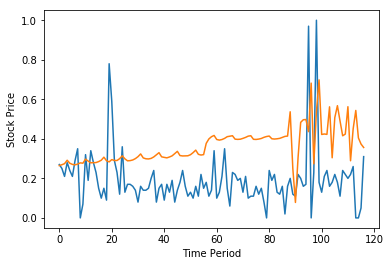

[step: 0] loss: 67.95417785644531
[step: 1] loss: 50.66910934448242
[step: 2] loss: 37.78627395629883
[step: 3] loss: 28.170207977294922
[step: 4] loss: 20.8955135345459
[step: 5] loss: 15.513142585754395
[step: 6] loss: 11.980079650878906
[step: 7] loss: 10.356183052062988
[step: 8] loss: 10.381121635437012
[step: 9] loss: 11.198955535888672
[step: 10] loss: 11.816288948059082
[step: 11] loss: 11.735286712646484
[step: 12] loss: 10.974815368652344
[step: 13] loss: 9.809804916381836
[step: 14] loss: 8.570269584655762
[step: 15] loss: 7.5165696144104
[step: 16] loss: 6.785455226898193
[step: 17] loss: 6.395358562469482
[step: 18] loss: 6.280905723571777
[step: 19] loss: 6.335974216461182
[step: 20] loss: 6.455137252807617
[step: 21] loss: 6.561817169189453
[step: 22] loss: 6.615896224975586
[step: 23] loss: 6.606663227081299
[step: 24] loss: 6.541407108306885
[step: 25] loss: 6.435841083526611
[step: 26] loss: 6.307860851287842
[step: 27] loss: 6.174095630645752
[step: 28] loss: 6.04823

[step: 260] loss: 3.955673933029175
[step: 261] loss: 3.9509475231170654
[step: 262] loss: 3.9462430477142334
[step: 263] loss: 3.941563367843628
[step: 264] loss: 3.9369096755981445
[step: 265] loss: 3.932284355163574
[step: 266] loss: 3.927687883377075
[step: 267] loss: 3.923123598098755
[step: 268] loss: 3.918593406677246
[step: 269] loss: 3.9140994548797607
[step: 270] loss: 3.909646987915039
[step: 271] loss: 3.9052374362945557
[step: 272] loss: 3.9008731842041016
[step: 273] loss: 3.8965587615966797
[step: 274] loss: 3.8922955989837646
[step: 275] loss: 3.8880860805511475
[step: 276] loss: 3.8839330673217773
[step: 277] loss: 3.879837989807129
[step: 278] loss: 3.875800371170044
[step: 279] loss: 3.8718221187591553
[step: 280] loss: 3.8679025173187256
[step: 281] loss: 3.8640389442443848
[step: 282] loss: 3.860231876373291
[step: 283] loss: 3.8564794063568115
[step: 284] loss: 3.8527770042419434
[step: 285] loss: 3.8491241931915283
[step: 286] loss: 3.845517158508301
[step: 287] 

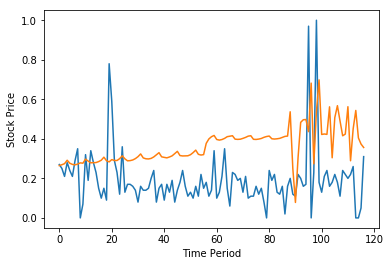

In [24]:
#train parameters
seq_length=7
data_dim=4
hidden_dim=10
output_dim=1
learning_rate=0.01
iterations=500
#기본형식
#기본 인자로는 ds-y로 받고 
#처리함수에서 ds를 받아서 'feature 처리모듈'에서 ds에서 요일(주중, 주말), 월(계절) + 날씨와 같은 추가 요인-값을 받는다.


x=xy
y=xy[:,[-1]]

#build a dataset
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]
    print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)

# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

#input place holders
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, 1])
# build a LSTM network(input: cell shape, type/ )
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# use the last cell's output to calculate Y_pred
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=tf.tanh) 
# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()
